<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/News_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 4.4MB/s 
     |████████████████████████████████| 460kB 32.7MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import html

class News:
  def __init__(self):
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_ranking(self, page=1, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = list(range(1,page+1))
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=RANK&date=' + date + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")

      div = bs_obj.find_all('div', {'class':'hotNewsList'})
      li+=[html.unescape(x['href']) for x in div[0].find_all('a')]
    return li

  def get_main(self, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y-%m-%d")) if date == '1' else date
    url = 'https://finance.naver.com/news/mainnews.nhn'
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return [x.find_all('a')[0]['href'] for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
    
  def get_breaking(self):
    pass

  # 시황 전망: 401
  # 기업 종목분석: 402
  # 해외 증시: 403
  # 채권 선물: 404
  # 공시 메모: 406
  # 환율: 429
  def get_focus(self, page=1, code=402, date='1', ):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = range(0,page)
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3='\
      + str(code) +  '&date=' + str(date) + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")
      temp = [html.unescape(x.find_all('a')[0]['href']) for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
      # 업데이트 가능
      li+=[x.replace('§', '&sect') for x in temp]
    return li

  def get_article(self, url):
    url = 'https://finance.naver.com/' + url
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    title = ' '.join(bs_obj.find_all('div', {'class': 'article_info'})[0].find_all('h3')[0].get_text().split())
    context = bs_obj.find_all('div', {'class': 'articleCont'})[0]
    try:
      subheading = context.find_all('strong')[0].get_text()
    except:
      subheading = ''
    t = ' '.join(context.get_text().split())
    text = t[:t.find('@')]
    text = text.replace(subheading, '')
    return title, subheading, text

In [14]:
from multiprocessing import Pool

news = News()
news_list = news.get_ranking(4)
with Pool(30) as p:
    li = p.map(news.get_article, news_list)
li = np.array(li)

dic = {'Title':li[:,0], 'Subheading':li[:,1], 'Text':li[:,2]}
df = pd.DataFrame.from_dict(dic)
df

,Title,Subheading,Text
0,피할 수 없을 가격 인상…라면株를 담아야 하는 이유,,"[머니투데이 구단비 기자] 농심, 오뚜기, 삼양식품 등 국내 주요 식품 업체들의 1..."
1,"13배 뛴 AMC… 2차 공매도전쟁, 서학개미들 대거 참전",공매도 몰려 연초 대비 13배 ↑‘게임스톱 사태’ 재현 가능성 우려,지난 1월 공매도와의 전쟁으로 글로벌 증시의 화제가 됐던 ‘게임스톱 사태’가 재현될...
2,"소외받던 5G 장비株, 해외 발판삼아 주가 반등 노린다",,[머니투데이 김영상 기자] 올해 상승장에서 가장 소외된 업종 중 하나로 꼽힌 5G(...
3,천당 지옥 오가는 스팩…투기세력 돌린 폭탄 개미가 떠안나,전날 14개 스팩 상한가 → 이날은 2개 하한가합병대상 없어도 주가 변동성 높아져…...,[이데일리 권효중 기자] “스팩주 지금이 기회입니다. 놓치지 마세요” “코인세력이 ...
4,"[특징주] '하루 쉰' 두산중공업, 11% 급등 마감",,경남 창원시 성산구 두산중공업. [연합뉴스 자료사진](서울=연합뉴스) 김태종 기자 ...
...,...,...,...
93,"영신금속, 오는 3일 무상증자 권리락 발생",,[이데일리 유준하 기자] 영신금속(007530)은 오는 3일 무상증자에 따른 권리락...
94,비케이탑스 전환사채 전환가액 9620원→8986원,,[이데일리 강민구 기자] 비케이탑스(030790)는 시가하락에 따라 ‘제7회차 무기...
95,"S-OIL, 1조5400억 규모 윤활기유 제품 공급계약 체결",,[아시아경제 김대현 기자] 에쓰오일(S-OIL)은 2일 MOTIVA ENTERPRI...
96,"[특징주]우진, 빌게이츠도 '눈독' SMR…그린수소 산업 필수 두산重 급등",소형 원자로 개발과 관련 정부 과제 참여소형 원자로용 계측기를 지속 개발,[아시아경제 박형수 기자] 소형모듈원자로(SMR) 기대가 커지면서 관련주가 강세다....


In [4]:
'''news = News()
dic = {'Title':[], 'Subheading':[], 'Text':[]}

for i in news.get_ranking(4):
  title, subheading, text = news.get_article(i)
  dic['Title'].append(title)
  dic['Subheading'].append(subheading)
  dic['Text'].append(text)

df = pd.DataFrame.from_dict(dic)
df'''

"news = News()\ndic = {'Title':[], 'Subheading':[], 'Text':[]}\n\nfor i in news.get_ranking(4):\n  title, subheading, text = news.get_article(i)\n  dic['Title'].append(title)\n  dic['Subheading'].append(subheading)\n  dic['Text'].append(text)\n\ndf = pd.DataFrame.from_dict(dic)\ndf"

In [5]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2021-06-02 10:12:03--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.2.112, 2607:f8b0:4004:80a::2010
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  70.7MB/s    in 1.6s    

2021-06-02 10:12:05 (70.7 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thi

(-0.5, 1199.5, 799.5, -0.5)

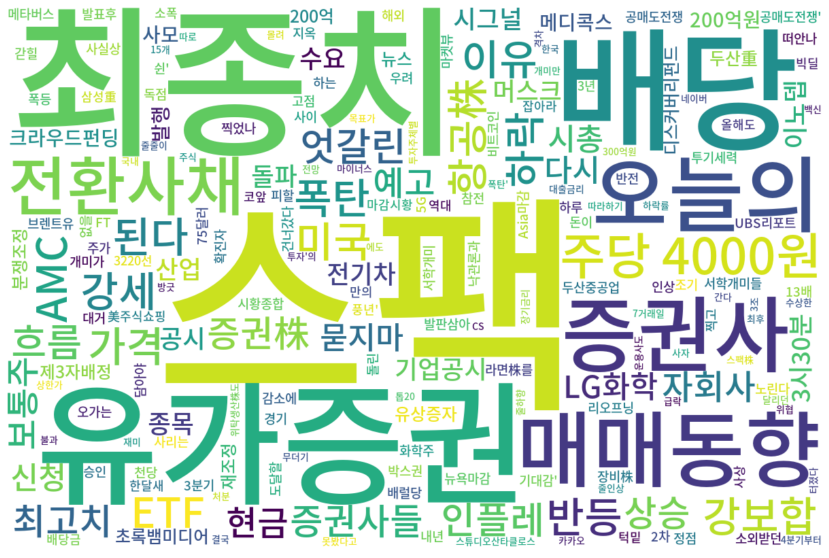

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['Title'].values)
stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
              '코스닥', '규모', '기관', '외국인', '결정', '증시', '3일', '코스피', '급등', '개인', '신영증권']
wordcloud = WordCloud(stopwords = stop_words, \
                      font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                      background_color='white', \
                      width=1200, height=800).generate(text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [7]:
# https://wikidocs.net/22530
# 불용어 제거 

from konlpy.tag import Hannanum

class Analyser:
  def __init__(self, news_df):
    self.news_df = news_df

  def get_tokenized_df(self):
    hannanum = Hannanum()
    return self.news_df.applymap(hannanum.pos)
     

In [8]:
analyser = Analyser(df)

In [9]:
hannanum = Hannanum()

def keyword_extractor(tagger, text):
    tokens = hannanum.morphs(text)
    tokens = [ token for token in tokens if len(token) > 1 ] # 한 글자인 단어는 제외
    count_dict = [(token, text.count(token)) for token in tokens ]
    ranked_words = sorted(count_dict, key=lambda x:x[1], reverse=True)[:10]
    return [ keyword for keyword, freq in ranked_words ]

In [10]:
print(keyword_extractor(hannanum, df['Text'][0]))

['가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격']


In [11]:
from konlpy.tag import Twitter

hannanum = Hannanum()
for i in range(0,len(df['Text'])):
  print(keyword_extractor(hannanum, df['Text'][i]))

['가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격', '가격']
['공매도', '공매도', '공매도', '공매', '공매', '공매', '공매', '공매', '공매', '공매']
['5G', '5G', '5G', '5G', '5G', '5G', '5G', '5G', '으로', '으로']
['스팩', '스팩', '스팩', '스팩', '스팩', '스팩', '스팩', '스팩', '스팩', '스팩']
['두산', '두산중공업', '두산중공업', '두산중공업', '상승', '두산중공업', '상승', '상승', '원전', '기대감']
['미국', '미국', '미국', '미국', '미국', '미국', '미국', '미국', '미국', '미국']
['%)', '%)', '%)', '%)', '%)', '%)', '%)', '%)', '%)', '%),']
['배럴', '배럴', '배럴', '배럴', '배럴', '배럴', '배럴', '배럴', 'OPEC', '으로']
['면서', '면서', '면서', '면서', '면서', '면서', '상승', '상승', '지수', '상승']
['미국', '미국', '미국', '미국', '미국', '미국', '재화', '소비', '증시', '증시']
['화학', '화학', '실적', '실적', '실적', '실적', '하락', '하락', '하락', '분기']
['메타버스', '메타버스', '메타버스', '메타버스', '메타버스', '로블록스', '관련주', '로블록스', '로블록스', '플랫폼']
['ETF', '상장', 'ETF', '상장', '상장', 'ETF', '상장', 'ETF', '상장', 'ETF']
['증시', '증시', '증시', '증시', '마감', '이날', '마감', '이날', '마감', '이날']
['달러', '달러', '달러', '달러', '달러', '지수', '지수', '으로', '으로', '으로']
['증자', '증자', '증자', '삼성', '유상증자', '유상증자', '유

In [23]:
'''!pip install newspaper3k
from newspaper import Article
url = 'https://finance.naver.com/news/news_read.nhn?article_id=0004944778&office_id=018&mode=mainnews&type=&date=2021-06-01&page=1'
a = Article(url, language='ko')
a.download()
a.parse()
print(a.title)
print(a.text)'''

     |████████████████████████████████| 215kB 13.2MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 7.4MB 41.2MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp37-none-any.whl size=7398406 sha256=38900d96c8b178170729c532d10dd085f0d52a322bff1d5dfac73b62ec30f455
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=f598e762d2315b423aeedfda853f040ecc57f21dec474b66eb54cbdc721b6e9c
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=b46afeafd939d2b24148f39e719a0b21a305a9e1bc6179438a9682267ce65ba6
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7

In [13]:
s= 

SyntaxError: ignored